## Emergency Department (ED) System Case Study (Operational Research)
### ***Modelling Hospital ED System Operations with SimPy***
**Objectives:** To model performance of ED System set-up to understand system efficieny and patient experience

***Entities:** Patients, **Resources:** Doctors, Nurses & ED Beds*
- <Insert process flow, Inputs & Simulation outputs to measure performance>

**Use of Probability Distributions:**
- Normal Distribution (mean & standard deviation) to model wait times
    - eg. use mean consult time of 20mins with SD of 5mins (meaning on average, each data point for consult time differs from mean by 5 mins)
- Exponential Distribution to model patient inter-arrival times
    - The probability distribution of the time between events in a Poisson point process, i.e., a process in which events occur continuously and independently at a constant average rate λ (λ > 0). 
    - Simplified best distribution to model inter-arrival times between patients (when supplemented with average interval times from hospital records)

In [1]:
# Import dependencies
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt


#### Breakdown of wait times for each process 
*Needs to be backed by domain from ED*
- **Consulting a doctor:** Normal Distribution with mean of 20mins & SD of 5mins, minimum 5mins.
- **Waiting for medications:** Normal Distribution with mean of 15mins & SD of 3mins, minimum 5mins.
- **Lab-test (fast):** Normal Distribution with mean of 25mins & SD of 5mins, minimum 10mins.
- **Lab-test (main ED):** Normal Distribution with mean of 40mins & SD of 10mins, minimum 15mins.
- **Review after lab-test:** Normal Distribution with mean of 10mins & SD of 3mins, minimum 3mins.
- **Admission for further treatment:** Normal Distribution with mean of 30mins & SD of 5mins, minimum 5mins.

In [2]:
# Create Hosptal class to store resources and events/processes
class Hospital(object): 
    def __init__(self, env, num_fast_doctors, num_fast_nurses, num_ed_doctors, num_ed_nurses, num_beds): 
        self.env = env
        self.fast_doctor = simpy.Resource(env, num_fast_doctors)
        self.fast_nurse = simpy.Resource(env, num_fast_nurses)
        self.ed_doctor = simpy.Resource(env, num_ed_doctors)
        self.ed_nurse = simpy.Resource(env, num_ed_nurses)
        self.beds = simpy.Resource(env, num_beds)

    # consulting a doctor
    def consult(self, patient): 
        service_time = np.random.normal(20, 5)
        service_time = max(5, service_time) # no negative durations
        yield self.env.timeout(service_time)
    
    # wait for medications
    def medication(self, patient): 
        service_time = np.random.normal(15, 3)
        service_time = max(5, service_time)
        yield self.env.timeout(service_time)

    # wait for lab-test (fast-track)
    def fast_lab(self, patient): 
        service_time = np.random.normal(25, 5)
        service_time = max(10, service_time)
        yield self.env.timeout(service_time)
    
     # wait for lab-test (main ED)
    def ed_lab(self, patient): 
        service_time = np.random.normal(40, 10)
        service_time = max(15, service_time)
        yield self.env.timeout(service_time)

    # review - after taking lab-test
    def review(self, patient):
        service_time = np.random.normal(10, 3)
        service_time = max(3, service_time)
        yield self.env.timeout(service_time)

    # re-admission to other dept for further treatment
    def admit(self, patient): 
        service_time = np.random.normal(30, 5)
        service_time = max(5, service_time)
        yield self.env.timeout(service_time)

In [3]:
## Store variables - Queue tracking
queue_fast, queue_ed = [], []

## Store wait times & timeline (for plots)
wait_times, timeline = [], []

## Utilizations
util_fast_doc = []
util_fast_nurse = []
util_ed_doc = []
util_ed_nurse = []
util_beds = []


##### [Inserts Process flow]

##### Breakdown of probabilities for event splits
- **Fast-track vs Main ED Patient:** 30% probability that patient is admitted to fast-track vice-versa
- **Lab-test for fast-track patients:** 30% probability that fast-track patient requires lab-test
- **Lab-test for main ED patients:** 70% probability that main ED patient requires lab-test
- **Admissions for main ED patients:** 50% probability that main ED patient will be admitted for further treatment.

In [4]:
# Define patient process - Refer to process flow above.
def patient(env, patient, hospital):
    arrival_time = env.now
    is_fast_track = random.random() < 0.3  # 30% go to fast-track

    if is_fast_track:
        # Step 1: consult doctor
        with hospital.fast_doctor.request() as request:
            yield request
            yield env.process(hospital.consult(patient))

        # Step 2: lab test - 30% chance
        if random.random() < 0.3:
            with hospital.fast_nurse.request() as request:
                yield request
                yield env.process(hospital.fast_lab(patient))
            # doctor's review
            with hospital.fast_doctor.request() as request:
                yield request
                yield env.process(hospital.review(patient))

        # Step 3: medication
        with hospital.fast_nurse.request() as request:
            yield request
            yield env.process(hospital.medication(patient))

    else:
        # Step 1: consult ED doctor
        with hospital.ed_doctor.request() as request:
            yield request
            yield env.process(hospital.consult(patient))

        # Step 2: lab test - 70% chance
        if random.random() < 0.7:
            with hospital.ed_nurse.request() as request:
                yield request
                yield env.process(hospital.ed_lab(patient))
            # doctor's review
            with hospital.ed_doctor.request() as request:
                yield request
                yield env.process(hospital.review(patient))

        # Step 3: admission OR medication
        if random.random() < 0.5:
            with hospital.beds.request() as bed_req:
                yield bed_req
                yield env.process(hospital.admit(patient))
        else:
            with hospital.ed_nurse.request() as nurse_req:
                yield nurse_req
                yield env.process(hospital.medication(patient))

    wait_times.append(env.now - arrival_time)

##### Monitor function to track metrics (every 5 minutes): 
1. Queue lengths for fast-track and Main ED patients
2. Utilisation of resources - Doctors, Nurses (for both Fast-Track and Main ED processes) + Beds (Main ED process)

In [ ]:
# Monitor function 
def monitor(env, hospital, timeline,
            queue_fast, queue_ed,
            util_fast_doc, util_fast_nurse,
            util_ed_doc, util_ed_nurse,
            util_beds,
            interval=5):
    while True:
        # Time snapshot
        timeline.append(env.now)

        # Queue lengths
        q_fast = len(hospital.fast_doctor.queue) + len(hospital.fast_nurse.queue)
        q_ed = len(hospital.ed_doctor.queue) + len(hospital.ed_nurse.queue)
        queue_fast.append(q_fast)
        queue_ed.append(q_ed)

        # Utilizations - .count = how many patients are currently served..capacity = total number.
        util_fast_doc.append(hospital.fast_doctor.count / hospital.fast_doctor.capacity)
        util_fast_nurse.append(hospital.fast_nurse.count / hospital.fast_nurse.capacity)
        util_ed_doc.append(hospital.ed_doctor.count / hospital.ed_doctor.capacity)
        util_ed_nurse.append(hospital.ed_nurse.count / hospital.ed_nurse.capacity)
        util_beds.append(hospital.beds.count / hospital.beds.capacity)

        yield env.timeout(interval)

In [6]:
# Report generation function
def report(wait_times, timeline,
           queue_fast, queue_ed,
           util_fast_doc, util_fast_nurse,
           util_ed_doc, util_ed_nurse,
           util_beds):

    print("=== Hospital ED Simulation Metrics ===")
    print(f"Average Wait Time (min): {np.mean(wait_times):.2f}")
    print(f"Max Wait Time (min): {np.max(wait_times):.2f}\n")

    print("--- Queue Lengths ---")
    print(f"Avg Fast-Track Queue Length: {np.mean(queue_fast):.2f}")
    print(f"Avg Main ED Queue Length:    {np.mean(queue_ed):.2f}\n")

    print("--- Resource Utilizations ---")
    print(f"Fast-Track Doctor Util (%):  {100 * np.mean(util_fast_doc):.2f}")
    print(f"Fast-Track Nurse Util (%):   {100 * np.mean(util_fast_nurse):.2f}")
    print(f"Main ED Doctor Util (%):     {100 * np.mean(util_ed_doc):.2f}")
    print(f"Main ED Nurse Util (%):      {100 * np.mean(util_ed_nurse):.2f}")
    print(f"Bed Utilization (%):         {100 * np.mean(util_beds):.2f}")

    # === Plotting ===
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 10))

    # Plot 1: Queue Lengths
    plt.subplot(2, 2, 1)
    plt.plot(timeline, queue_fast, label="Fast-Track Queue")
    plt.plot(timeline, queue_ed, label="Main ED Queue")
    plt.xlabel("Time (min)")
    plt.ylabel("Queue Length")
    plt.title("Queue Lengths Over Time")
    plt.legend()
    plt.grid(True)

    # Plot 2: Doctor Utilization
    plt.subplot(2, 2, 2)
    plt.plot(timeline, util_fast_doc, label="Fast-Track Doctor")
    plt.plot(timeline, util_ed_doc, label="Main ED Doctor")
    plt.xlabel("Time (min)")
    plt.ylabel("Utilization (0-1)")
    plt.title("Doctor Utilization Over Time")
    plt.legend()
    plt.grid(True)

    # Plot 3: Nurse Utilization
    plt.subplot(2, 2, 3)
    plt.plot(timeline, util_fast_nurse, label="Fast-Track Nurse")
    plt.plot(timeline, util_ed_nurse, label="Main ED Nurse")
    plt.xlabel("Time (min)")
    plt.ylabel("Utilization (0-1)")
    plt.title("Nurse Utilization Over Time")
    plt.legend()
    plt.grid(True)

    # Plot 4: Bed Utilization
    plt.subplot(2, 2, 4)
    plt.plot(timeline, util_beds, label="Bed Utilization", color='brown')
    plt.xlabel("Time (min)")
    plt.ylabel("Utilization (0-1)")
    plt.title("Admission Bed Utilization")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 151.64
Max Wait Time (min): 446.53

--- Queue Lengths ---
Avg Fast-Track Queue Length: 2.81
Avg Main ED Queue Length:    6.87

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  77.00
Fast-Track Nurse Util (%):   75.00
Main ED Doctor Util (%):     58.83
Main ED Nurse Util (%):      92.00
Bed Utilization (%):         15.90


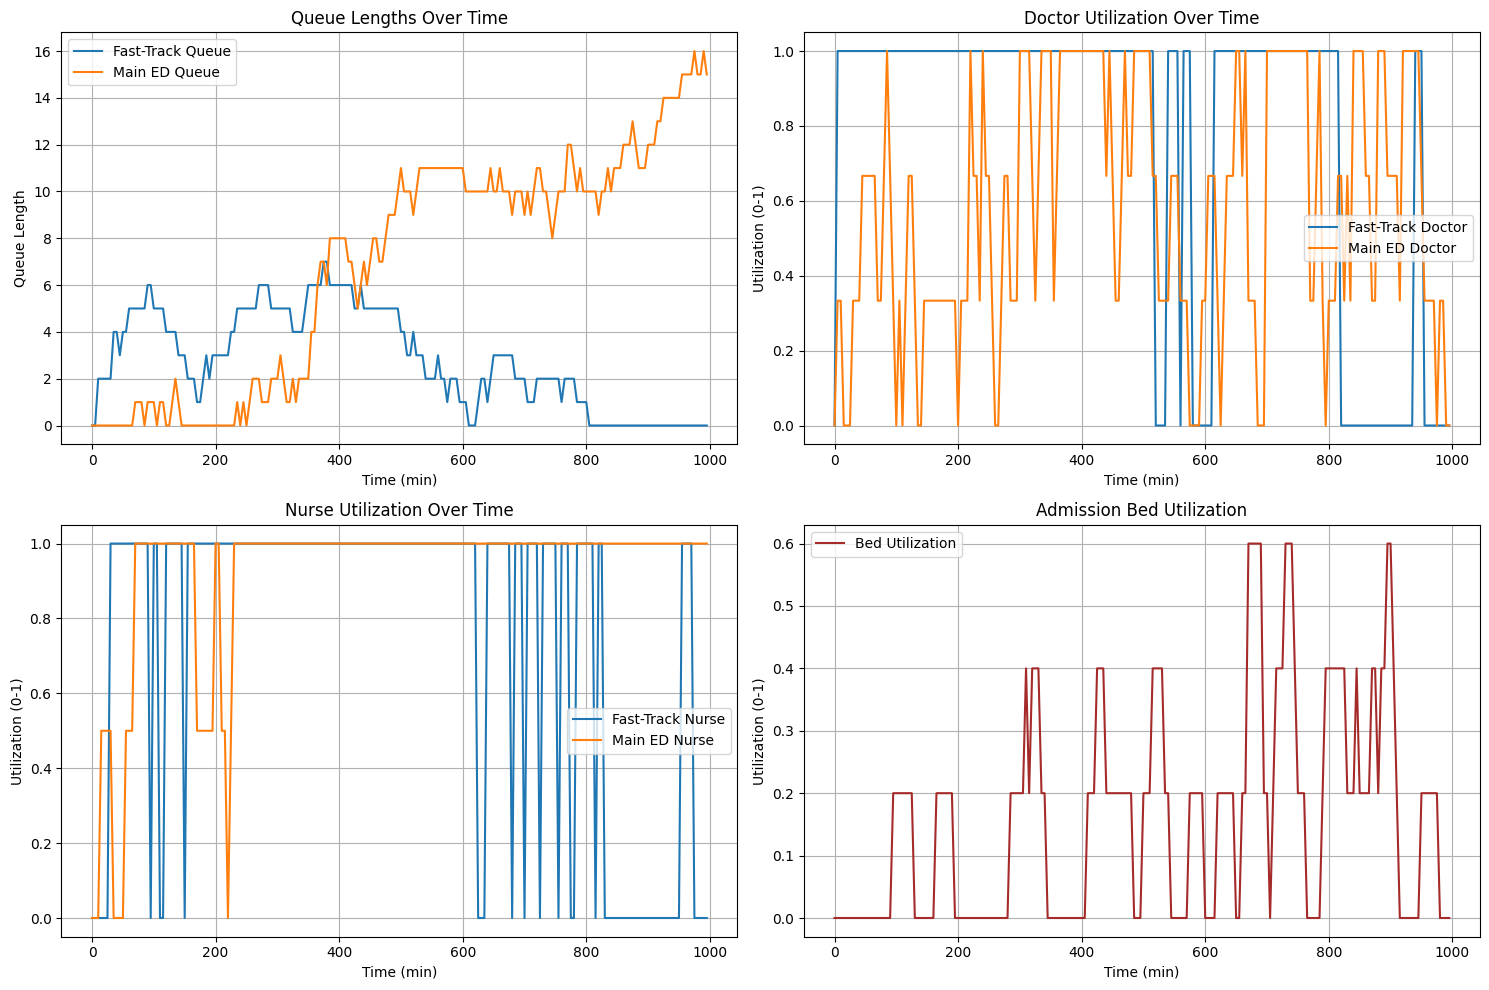

In [ ]:
# Set input variables
ARRIVAL_RATE = 10 # mean inter-arrival time
N_PATIENTS = 100
SIM_TIME = 1440 # mins - 24 hours

# --- Run Simulation ---
random.seed(42)
np.random.seed(42)
env = simpy.Environment()
hospital = Hospital(env, 1, 1, 3, 2, 5)

# Schedule patient arrivals
def source(env, Hospital, n_patients):
    for i in range(n_patients):
        env.process(patient(env, f"Patient {i+1}", hospital))
        yield env.timeout(np.random.exponential(ARRIVAL_RATE))

env.process(source(env, hospital, N_PATIENTS))
env.process(monitor(env, hospital, timeline,
                    queue_fast, queue_ed,
                    util_fast_doc, util_fast_nurse,
                    util_ed_doc, util_ed_nurse,
                    util_beds))
env.run(until=SIM_TIME)

# --- Report ---
report(wait_times, timeline,
       queue_fast, queue_ed,
       util_fast_doc, util_fast_nurse,
       util_ed_doc, util_ed_nurse,
       util_beds)
